In [1]:
!pip install kneed

#Imports

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from time import time


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ruthgn/beer-profile-and-ratings-data-set
!unzip /content/beer-profile-and-ratings-data-set.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ruthgn/beer-profile-and-ratings-data-set
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/492k [00:00<?, ?B/s]
100% 492k/492k [00:00<00:00, 15.2MB/s]
Archive:  /content/beer-profile-and-ratings-data-set.zip
  inflating: Beer Descriptors Simplified.xlsx  
  inflating: Beer Name Fuzzy Match List.csv  
  inflating: Brewery Name Fuzzy Match List.csv  
  inflating: beer_profile_and_ratings.csv  


#Data Understanding

##Data Quality

In [4]:
file_path = '/content/beer_profile_and_ratings.csv'
beer_data = pd.read_csv(file_path)

# check for missing values
missing_values = beer_data.isnull().sum()
print(missing_values)

# check for duplicates
duplicate_rows = beer_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")


Name                 0
Style                0
Brewery              0
Beer Name (Full)     0
Description          0
ABV                  0
Min IBU              0
Max IBU              0
Astringency          0
Body                 0
Alcohol              0
Bitter               0
Sweet                0
Sour                 0
Salty                0
Fruits               0
Hoppy                0
Spices               0
Malty                0
review_aroma         0
review_appearance    0
review_palate        0
review_taste         0
review_overall       0
number_of_reviews    0
dtype: int64

Number of duplicate rows: 0


##Data Description and Exploration

In [5]:
# structure of the dataset

beer_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3197 non-null   object 
 1   Style              3197 non-null   object 
 2   Brewery            3197 non-null   object 
 3   Beer Name (Full)   3197 non-null   object 
 4   Description        3197 non-null   object 
 5   ABV                3197 non-null   float64
 6   Min IBU            3197 non-null   int64  
 7   Max IBU            3197 non-null   int64  
 8   Astringency        3197 non-null   int64  
 9   Body               3197 non-null   int64  
 10  Alcohol            3197 non-null   int64  
 11  Bitter             3197 non-null   int64  
 12  Sweet              3197 non-null   int64  
 13  Sour               3197 non-null   int64  
 14  Salty              3197 non-null   int64  
 15  Fruits             3197 non-null   int64  
 16  Hoppy              3197 

In [6]:
# basic statistics of numerical columns

numerical_description = beer_data.describe()
numerical_description = numerical_description.round(2)
numerical_description.to_excel('numerical_statistics_table.xlsx', index = True)
numerical_description


,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
count,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00,3197.00
mean,6.53,21.18,38.99,16.52,46.13,17.06,36.36,58.27,33.15,1.02,38.53,40.92,18.35,75.33,3.64,3.75,3.66,3.70,3.75,233.28
std,2.55,13.24,21.36,10.41,25.95,17.33,25.79,34.28,35.78,2.13,32.30,30.40,23.76,39.91,0.50,0.40,0.45,0.51,0.44,361.81
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.51,1.57,1.29,1.21,1.14,1.00
25%,5.00,15.00,25.00,9.00,29.00,6.00,17.00,33.00,11.00,0.00,12.00,18.00,4.00,45.00,3.42,3.60,3.47,3.50,3.57,23.00
50%,6.00,20.00,35.00,14.00,40.00,11.00,31.00,54.00,22.00,0.00,29.00,33.00,10.00,73.00,3.72,3.83,3.74,3.79,3.83,93.00
75%,7.60,25.00,45.00,21.00,58.00,22.00,52.00,77.00,42.00,1.00,60.00,56.00,23.00,103.00,3.98,4.00,3.97,4.03,4.03,284.00
max,57.50,65.00,100.00,81.00,175.00,139.00,150.00,263.00,284.00,48.00,175.00,172.00,184.00,239.00,5.00,4.67,5.00,5.00,5.00,3290.00


In [7]:
# basic statistics of categorical columns

categorical_description = beer_data.describe(include = ['object'])
categorical_description.to_excel('categorial_statistics_table.xlsx', index = True)
categorical_description


,Name,Style,Brewery,Beer Name (Full),Description
count,3197,3197,3197,3197,3197
unique,3066,111,934,3197,1841
top,Oktoberfest,Lager - Adjunct,Boston Beer Company (Samuel Adams),Alaskan Brewing Co. Alaskan Amber,Notes:
freq,12,45,40,1,1347


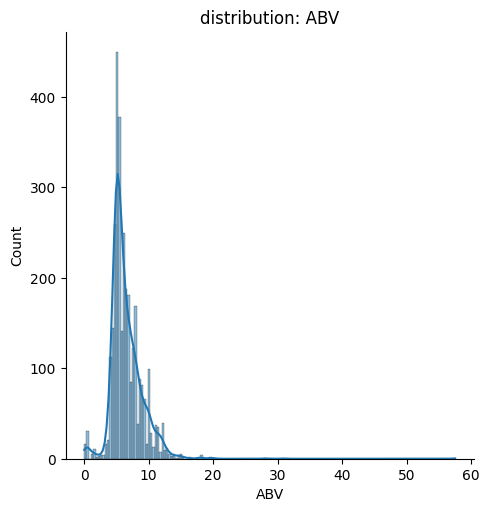

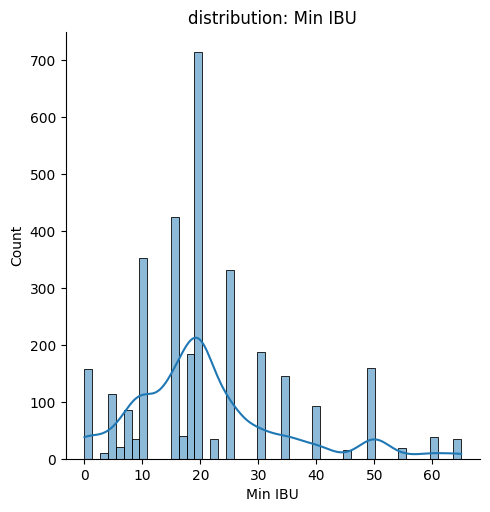

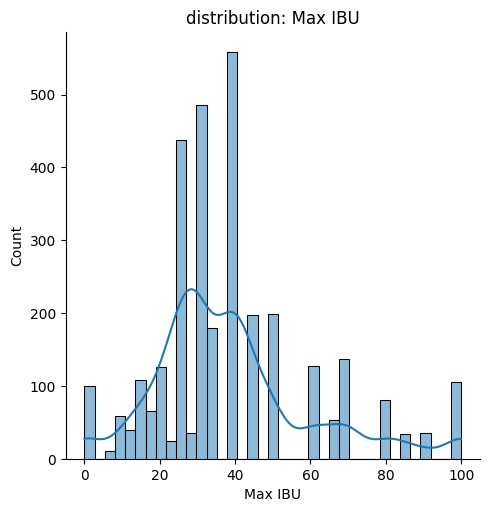

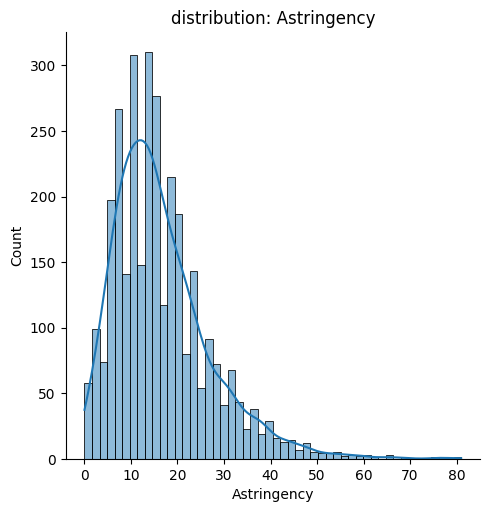

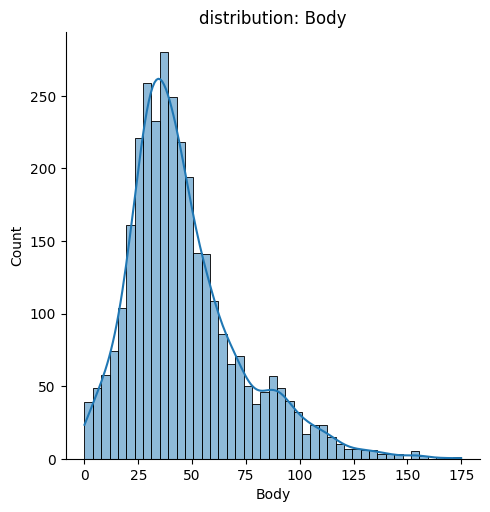

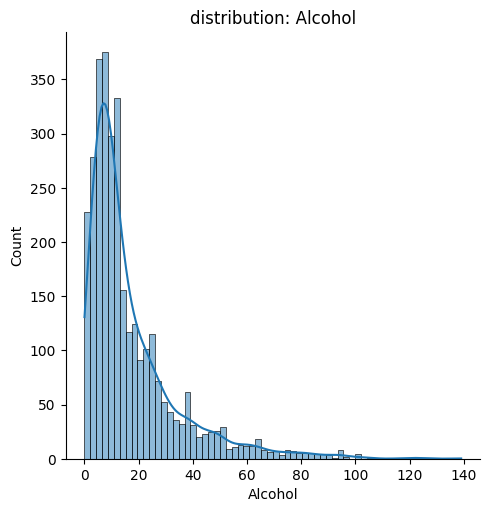

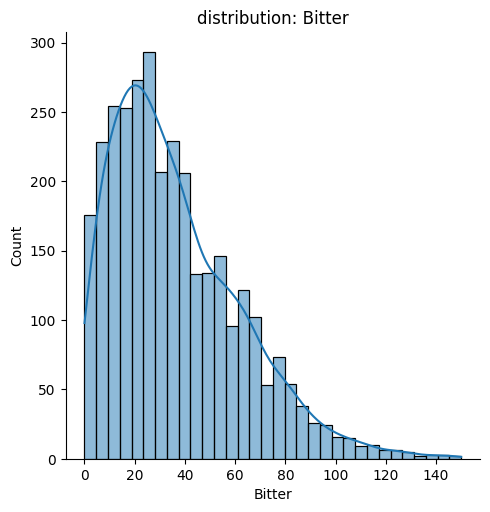

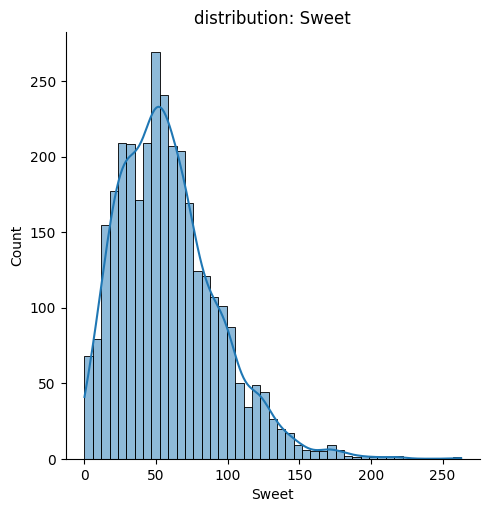

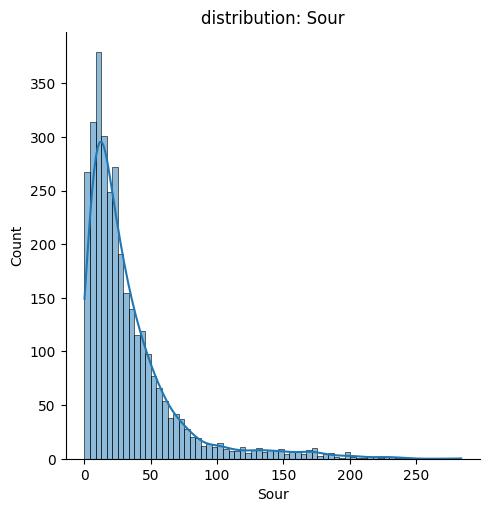

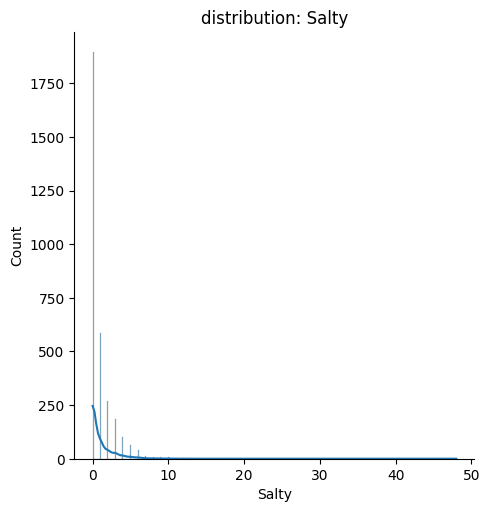

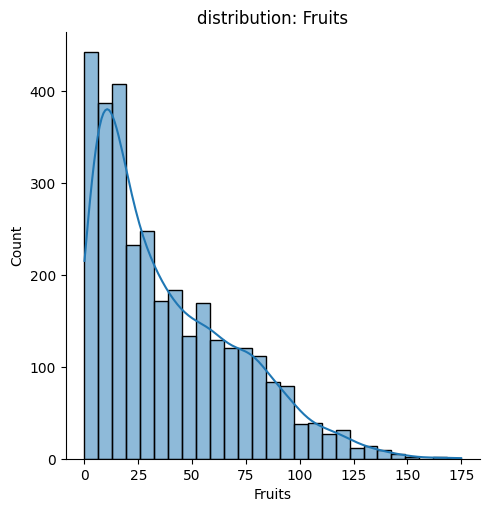

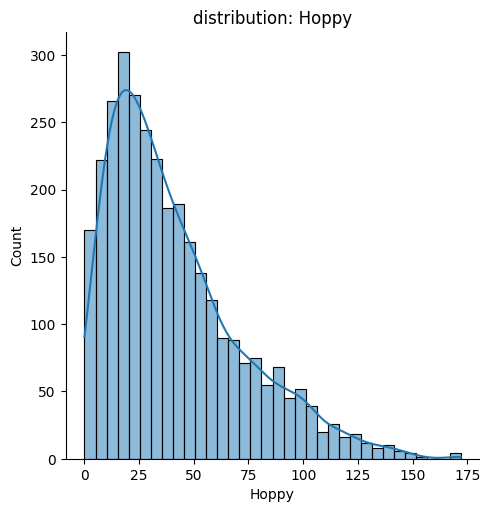

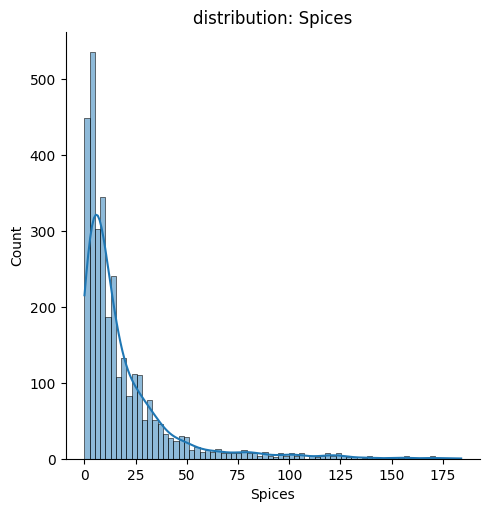

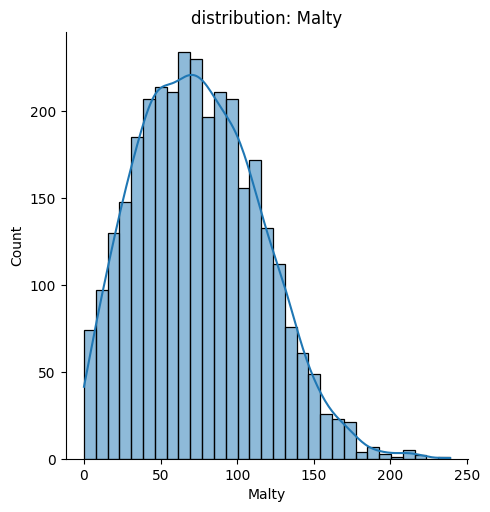

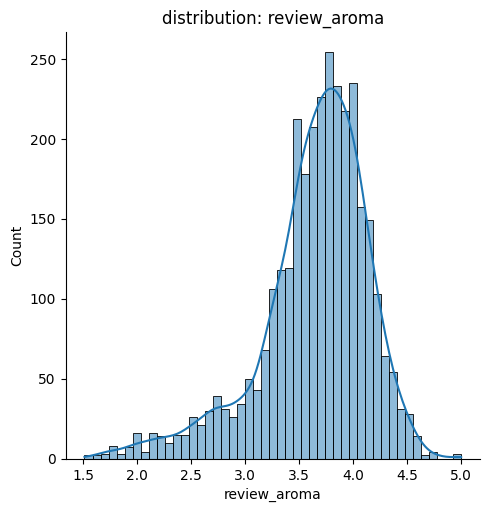

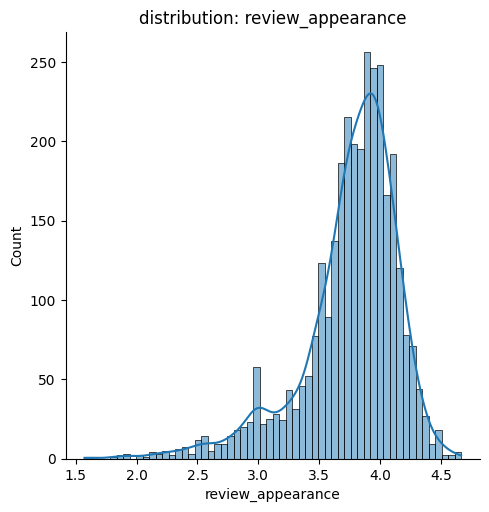

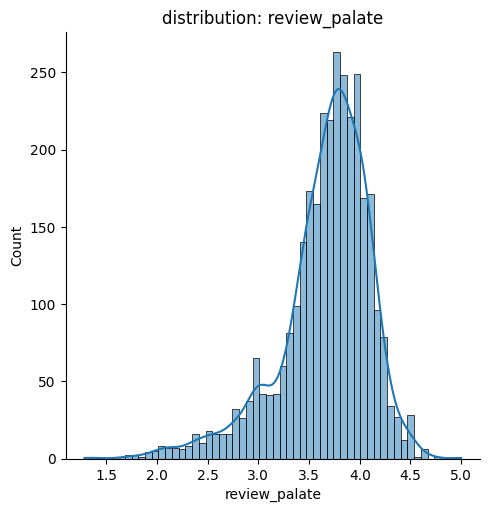

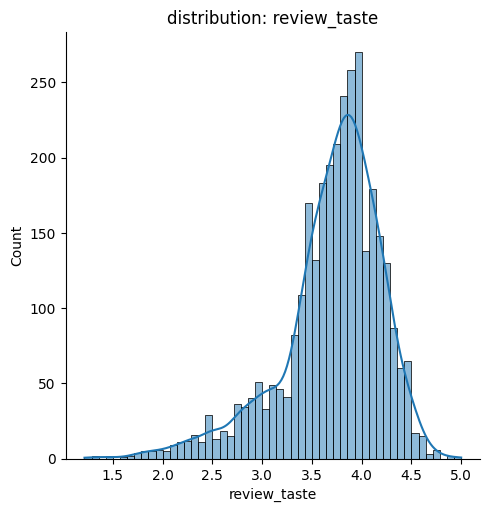

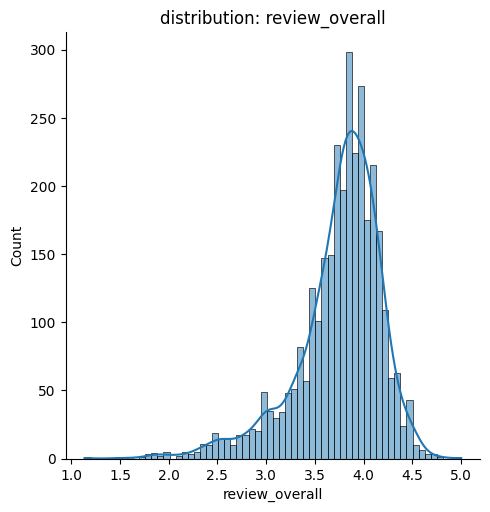

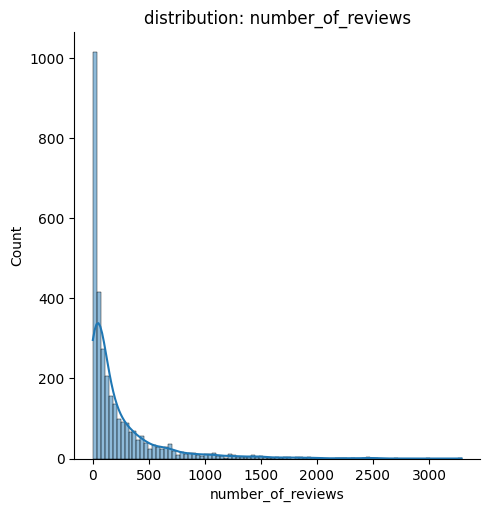

In [8]:
numeric_columns = beer_data.select_dtypes(include='number').columns
for col in numeric_columns:
  sns.displot(data=beer_data, x=col, kde=True).set(title='distribution: {}'.format(col))
  plt.show()

In [9]:
# correlations

# compute the correlation matrix
numeric_df_subset = beer_data.select_dtypes(include = ['int64', 'float64'])
correlation_matrix = numeric_df_subset.corr()
correlation_matrix_rounded = correlation_matrix.round(2)

# correlation of features with the target variable
target_correlation = correlation_matrix_rounded['review_overall'].sort_values(ascending = False)
print(target_correlation)

# exporting correlation matrix and target correlation to excel (same file for both)
output_file = 'correlation_matrix.xlsx'
with pd.ExcelWriter(output_file) as writer:
  correlation_matrix_rounded.to_excel(writer, sheet_name = 'Full Correlation Matrix')
  target_correlation.to_excel(writer, sheet_name = 'Target Correlation')


review_overall       1.00
review_taste         0.94
review_palate        0.92
review_aroma         0.87
review_appearance    0.81
Body                 0.31
Min IBU              0.29
Max IBU              0.27
Fruits               0.26
Bitter               0.26
ABV                  0.25
Malty                0.21
Sour                 0.21
Sweet                0.21
Hoppy                0.18
number_of_reviews    0.18
Astringency          0.16
Spices               0.14
Alcohol              0.07
Salty               -0.01
Name: review_overall, dtype: float64


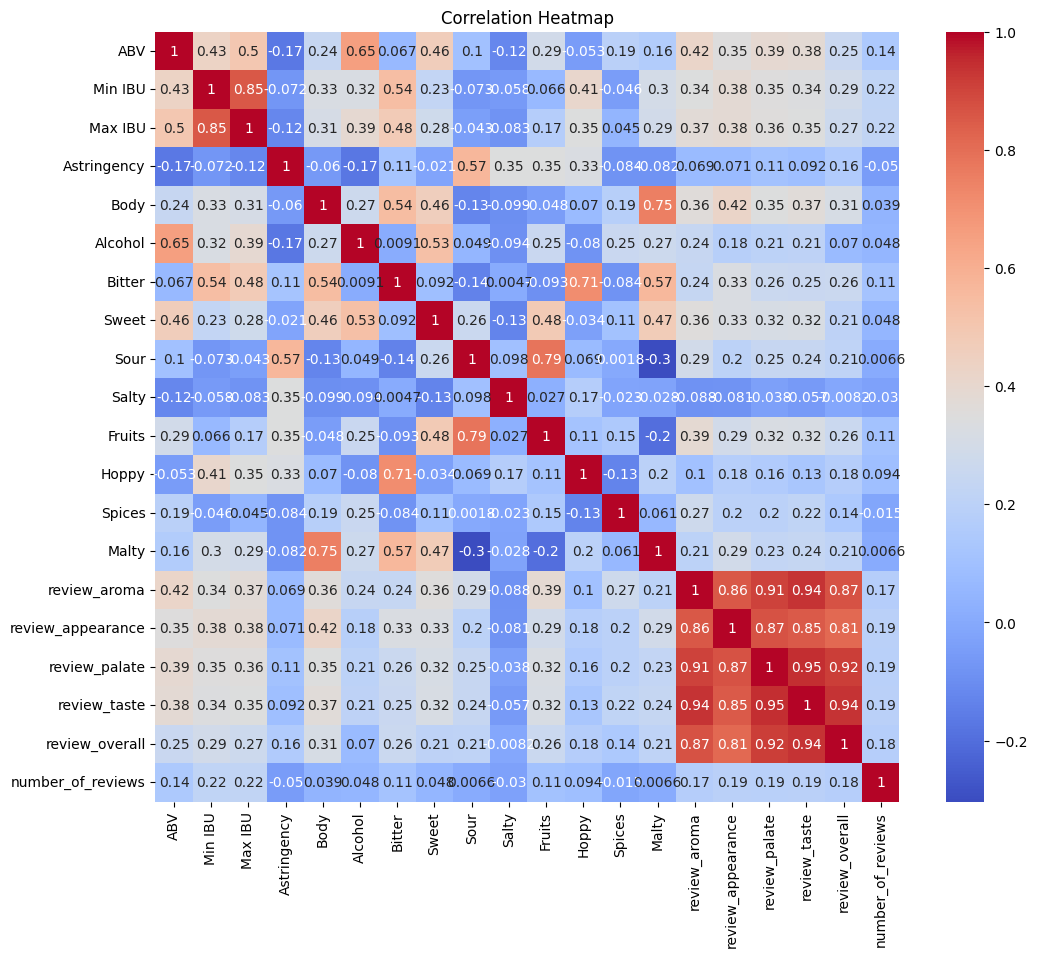

In [10]:
# correlation heatmap

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


#Preprocessing

In [11]:
# dropping correlated columns: hoppy, body, alcohol and all review fields expect review_overall
beer_data.drop(columns = ['Hoppy', 'Body', 'review_taste', 'review_palate', 'review_aroma', 'review_appearance', 'Sour','Min IBU'], inplace = True)

# dropping redundant columns: number of reviews, description, beer name (full), brewery, name
beer_data.drop(columns = ['number_of_reviews', 'Beer Name (Full)', 'Name', 'Brewery', 'Description', 'Style'], inplace = True)



In [12]:

numeric_features = ['Max IBU', 'ABV', 'Malty', 'Spices', 'Fruits', 'Salty', 'Sweet', 'Bitter', 'Astringency', 'Alcohol','review_overall']


In [13]:

df = beer_data[numeric_features]

# scale the numeric features
numeric_transformer = MinMaxScaler()
scaled_data = numeric_transformer.fit_transform(beer_data[numeric_features])
scaled_df = pd.DataFrame(scaled_data, columns = numeric_features)
df_scaled = scaled_df.copy()



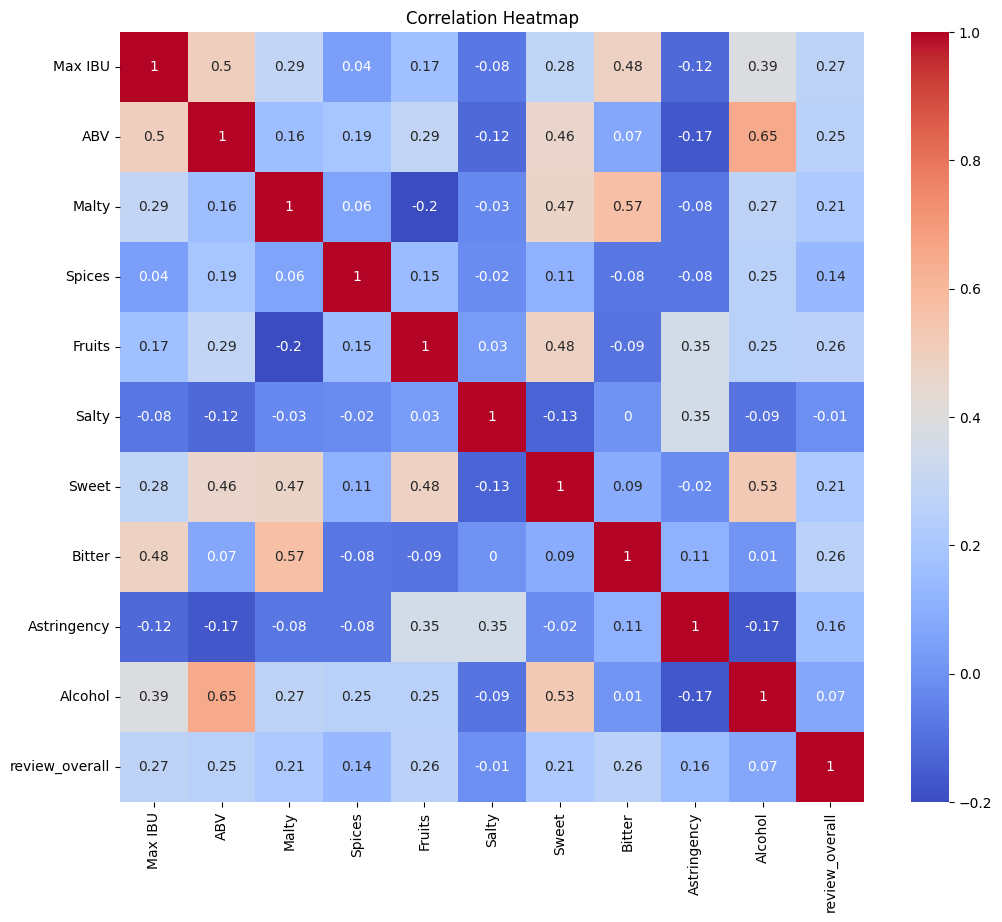

In [14]:
# compute the correlation matrix after scaling
numeric_df_subset = scaled_df.select_dtypes(include = ['int64', 'float64'])
correlation_matrix = numeric_df_subset.corr()
correlation_matrix_rounded = correlation_matrix.round(2)


plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix_rounded, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Modeling

##PCA

In [15]:
# finding desired number of PCA components

def get_n_components(df):
  pca = PCA().fit(df)
  cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
  n_components = np.argmax(cumulative_variance >= 0.9) + 1 # find the number of components for 90% variance
  return pca, n_components


Desired number of componenets: 6 



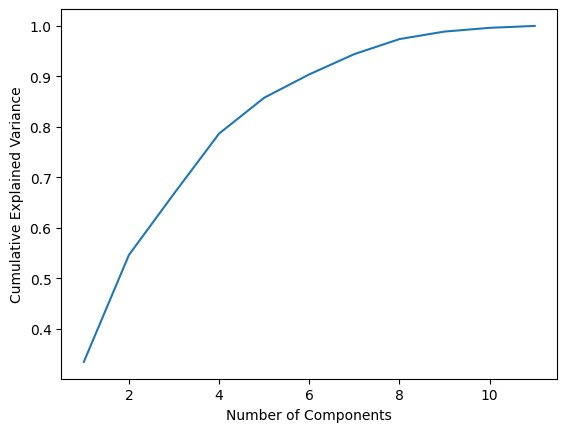

In [16]:
# finding desired number of components for *scaled data*

pca_df_scaled, n_components_df_scaled = get_n_components(df_scaled)
print('Desired number of componenets:', n_components_df_scaled, '\n')

plt.plot(range(1, len(pca_df_scaled.explained_variance_ratio_) + 1), np.cumsum(pca_df_scaled.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [17]:
pca_df, n_components_df = get_n_components(df)
pca_for_df = PCA(n_components = n_components_df)
pca_df = pca_for_df.fit_transform(df)

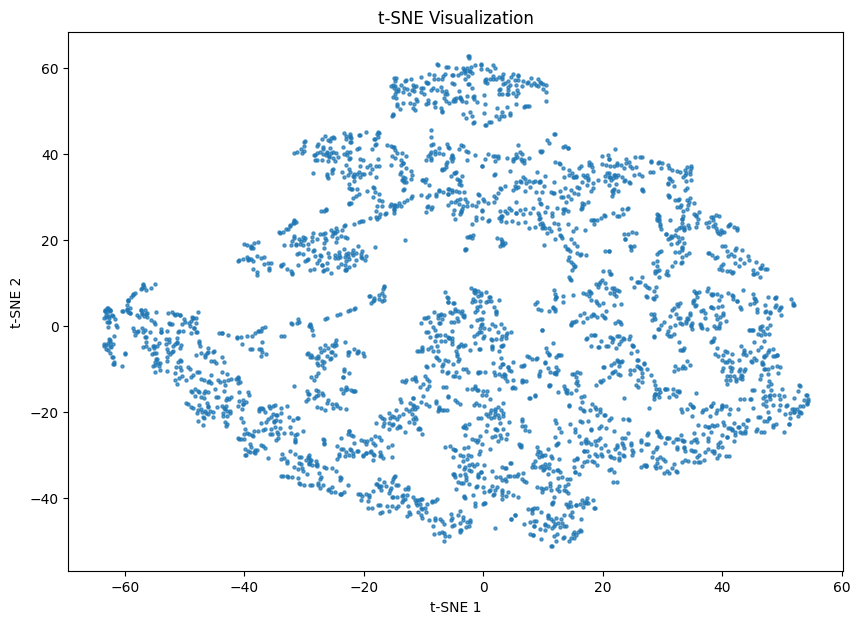

In [18]:
# apply t-SNE on the pca'ed *non-scaled data* to reduce dimensions to 2, simply for visualization

tsne = TSNE(n_components = 2, random_state = 42)
tsne_result = tsne.fit_transform(pca_df)

plt.figure(figsize = (10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s = 5, alpha = 0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization')
plt.show()


In [19]:
pca_for_df_scaled = PCA(n_components = n_components_df_scaled)
pca_df_scaled = pca_for_df_scaled.fit_transform(df_scaled)

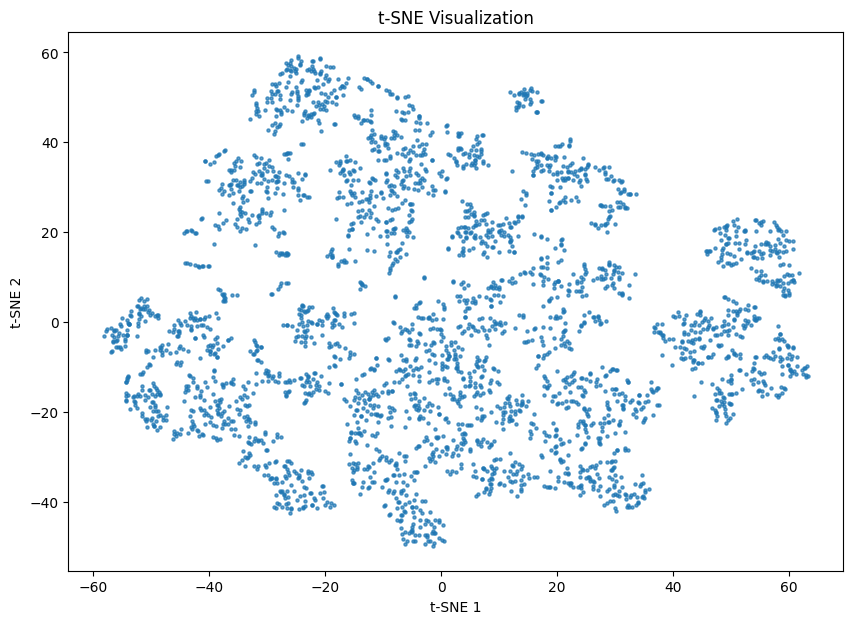

In [20]:
# apply t-SNE on the pca'ed *scaled data* to reduce dimensions to 2, simply for visualization

tsne = TSNE(n_components = 2, random_state = 42)
tsne_result = tsne.fit_transform(pca_df_scaled)

plt.figure(figsize = (10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s = 5, alpha = 0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization')
plt.show()


##Functions

In [21]:
# function to find optimal number of clusters based on data, index and model

def get_score(df, index, model, scale):
  scores = []
  min_clusters = 30
  max_clusters = 61
  high_or_low = None

  start_time = time()

  for i in range(min_clusters, max_clusters):
    # apply clustering
    if model == 'KMeans':
      model_clusters = KMeans(n_clusters = i, random_state = 42, n_init = 10)
      labels = model_clusters.fit_predict(df)
    elif model == 'GMM':
      model_clusters = GaussianMixture(n_components = i, random_state = 42)
      labels = model_clusters.fit_predict(df)
    elif model == 'Hierarchical':
      model_clusters = AgglomerativeClustering(n_clusters = i)
      labels = model_clusters.fit_predict(df)

    # evaluate the model
    if index == 'Silhouette':
      avg = silhouette_score(df, labels)
    elif index == 'Davies-Bouldin':
      avg = davies_bouldin_score(df, labels)

    scores.append(avg)

  if index == 'Silhouette':
    best_value = max(scores)
    rounded_best_value = round(max(scores), 3)
    high_or_low = 'highest'
  elif index == 'Davies-Bouldin':
    best_value = min(scores)
    rounded_best_value = round(min(scores), 3)
    high_or_low = 'lowest'

  best_index = scores.index(best_value)
  end_time = time()
  elapsed_time = end_time - start_time
  print(f'\n{model} {high_or_low} {index} score for {scale} data is: {rounded_best_value}, for {best_index + min_clusters} clusters\n')

  print(f'\nTotal time taken for {model} clustering to find the best {index} score on {scale} data: {elapsed_time:.2f} seconds\n')

  # visualize scores
  plt.figure(figsize = (10, 6))
  plt.plot(range(min_clusters, max_clusters), scores, marker = 'o', linestyle = '--', color = 'b')
  plt.xlabel('Number of Clusters')
  plt.ylabel(f'{index} Score')
  plt.title(f'{index} Score for {model} Clustering using PCA on {scale} Data')
  plt.xticks(range(min_clusters, max_clusters))
  plt.gca().xaxis.set_major_locator(AutoLocator())
  plt.xticks(rotation = 45)
  plt.show()


In [22]:
# function to visualize clusters, PCA on scaled data, based on data, model and number of components

def viz_clusering(df, model, n_clusters):
  if model == 'KMeans':
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 10)
    labels = kmeans.fit_predict(df)
  elif model == 'GMM':
    gmm = GaussianMixture(n_components = n_clusters, random_state = 42)
    labels = gmm.fit_predict(df)
  elif model == 'Hierarchical':
    hierarchical = AgglomerativeClustering(n_clusters = n_clusters)
    labels = hierarchical.fit_predict(df)

  tsne = TSNE(n_components = 2, random_state = 42)
  data_tsne = tsne.fit_transform(df)

  df_tsne = pd.DataFrame(data_tsne, columns = ['TSNE1', 'TSNE2'])
  df_tsne['Cluster'] = labels

  colors = list(mcolors.CSS4_COLORS.values())[:n_clusters] # get enough distinct colors

  plt.figure(figsize = (12, 8))
  for cluster in range(n_clusters):
    cluster_points = df_tsne[df_tsne['Cluster'] == cluster]
    plt.scatter(cluster_points['TSNE1'], cluster_points['TSNE2'], c = [colors[cluster]], label = f'Cluster {cluster}', marker = 'o', edgecolor = 'k', s = 50)

  plt.title(f'{model} Clustering with t-SNE')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.legend(loc = 'best', bbox_to_anchor = (1.05, 1), ncol = 1)
  plt.show()


## K-Means



KMeans highest Silhouette score for Scaled data is: 0.185, for 37 clusters


Total time taken for KMeans clustering to find the best Silhouette score on Scaled data: 39.41 seconds



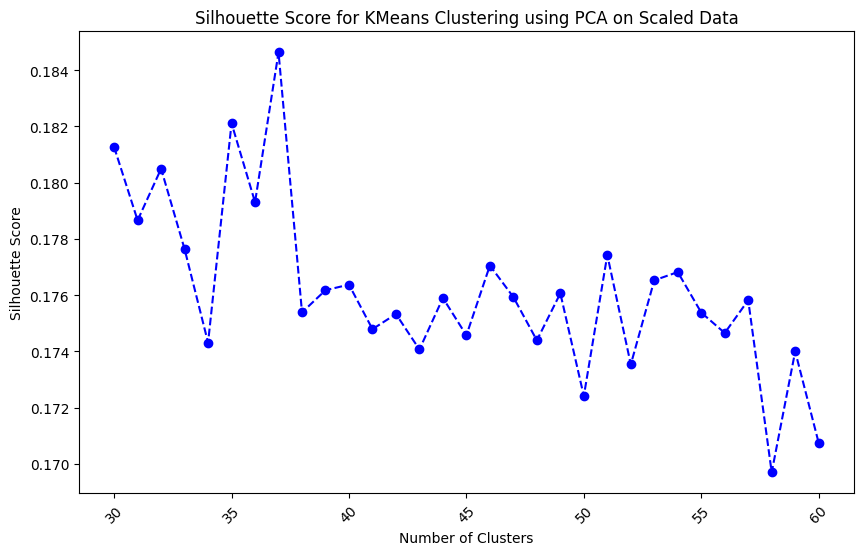


KMeans lowest Davies-Bouldin score for Scaled data is: 1.333, for 56 clusters


Total time taken for KMeans clustering to find the best Davies-Bouldin score on Scaled data: 31.94 seconds



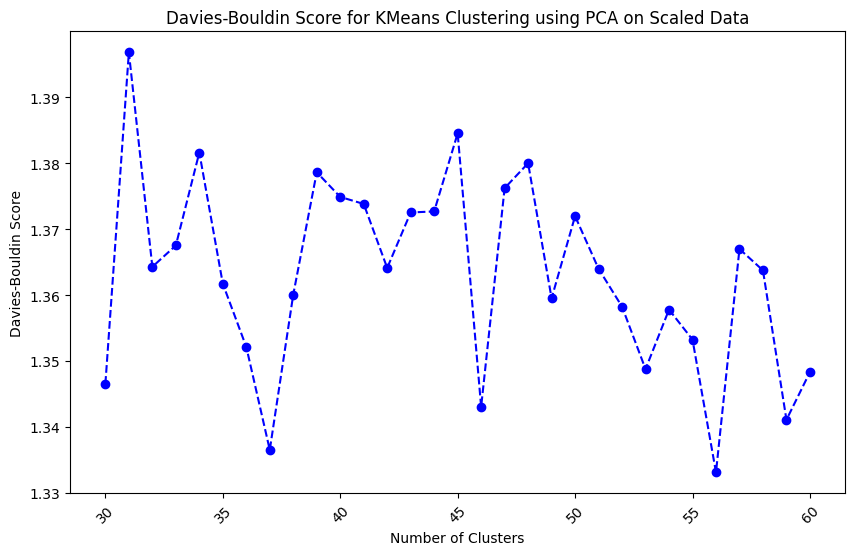

In [23]:
# scores for scaled data with PCA
get_score(pca_df_scaled, 'Silhouette', 'KMeans', 'Scaled')
get_score(pca_df_scaled, 'Davies-Bouldin', 'KMeans', 'Scaled')

## GMM


GMM highest Silhouette score for Scaled data is: 0.081, for 43 clusters


Total time taken for GMM clustering to find the best Silhouette score on Scaled data: 106.00 seconds



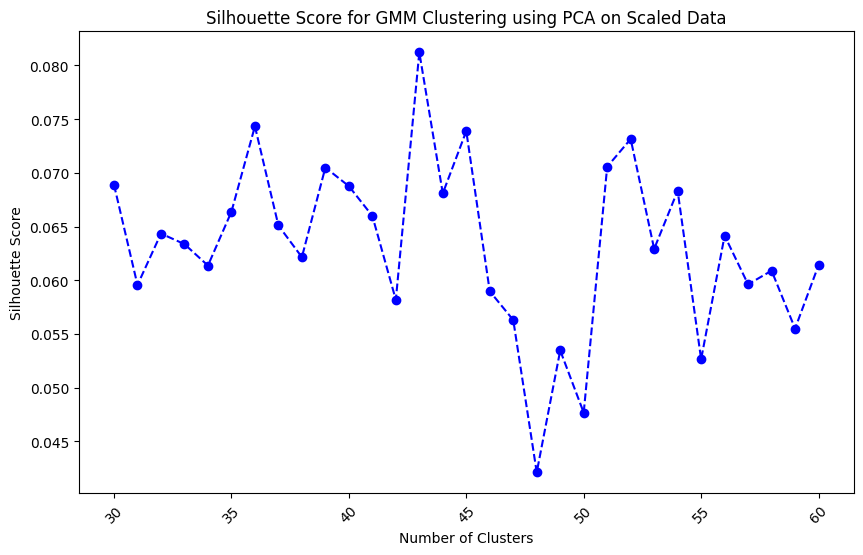


GMM lowest Davies-Bouldin score for Scaled data is: 1.808, for 52 clusters


Total time taken for GMM clustering to find the best Davies-Bouldin score on Scaled data: 98.36 seconds



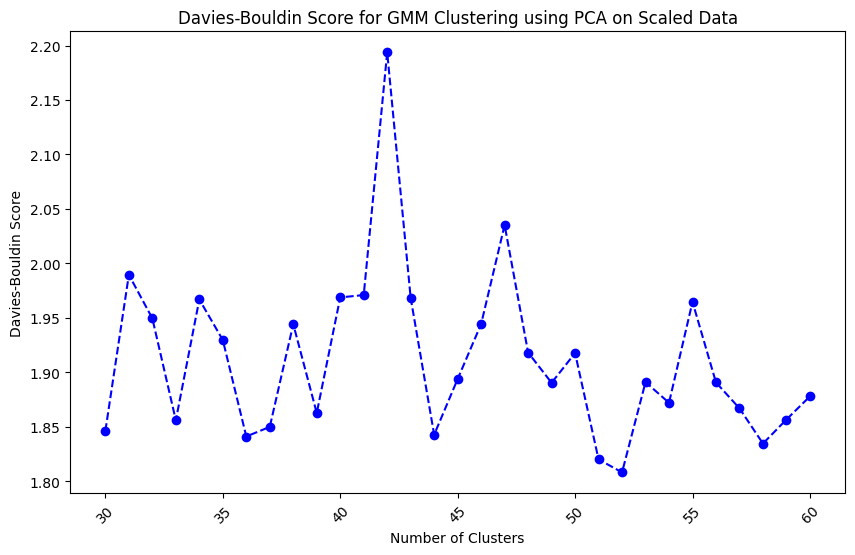

In [24]:

get_score(pca_df_scaled, 'Silhouette', 'GMM', 'Scaled')
get_score(pca_df_scaled, 'Davies-Bouldin', 'GMM', 'Scaled')

##Hierarchical


Hierarchical highest Silhouette score for Scaled data is: 0.142, for 31 clusters


Total time taken for Hierarchical clustering to find the best Silhouette score on Scaled data: 19.25 seconds



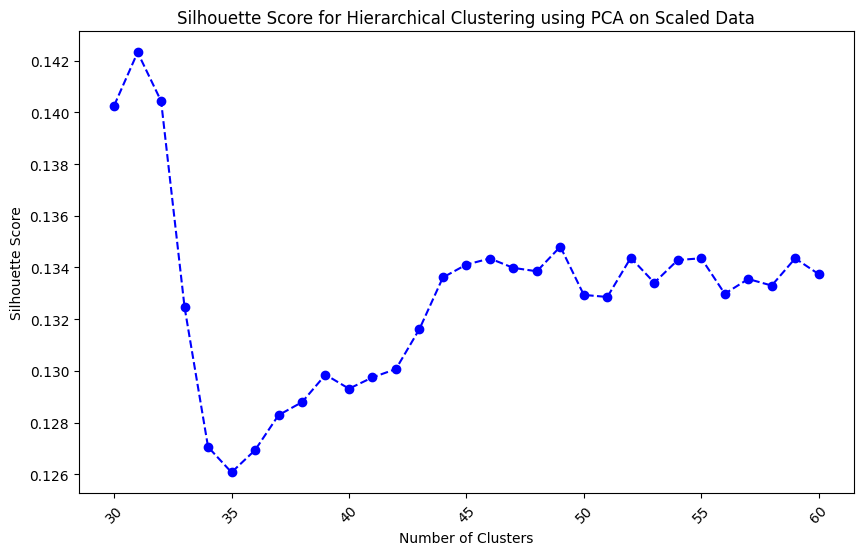


Hierarchical lowest Davies-Bouldin score for Scaled data is: 1.47, for 39 clusters


Total time taken for Hierarchical clustering to find the best Davies-Bouldin score on Scaled data: 12.81 seconds



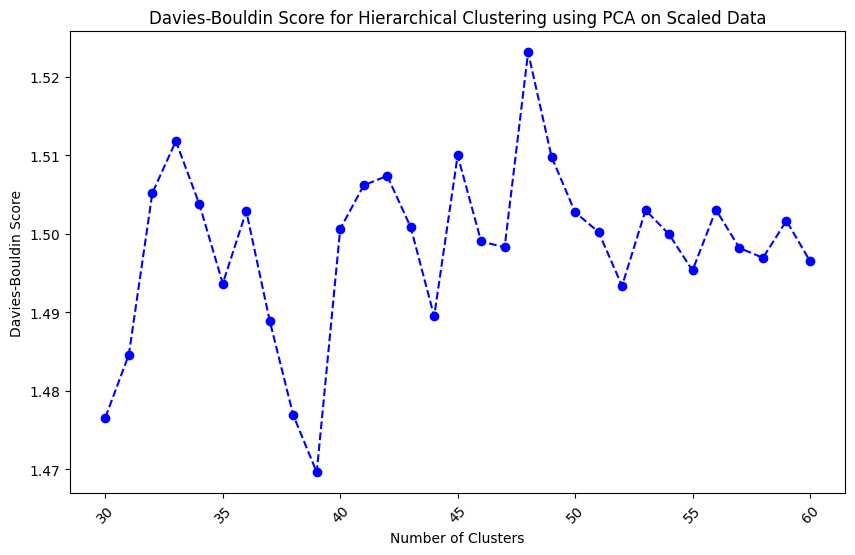

In [25]:

get_score(pca_df_scaled, 'Silhouette', 'Hierarchical', 'Scaled')
get_score(pca_df_scaled, 'Davies-Bouldin', 'Hierarchical', 'Scaled')

**We visualized the clusters based on the Davies-Bouldin score for the scaled data.**




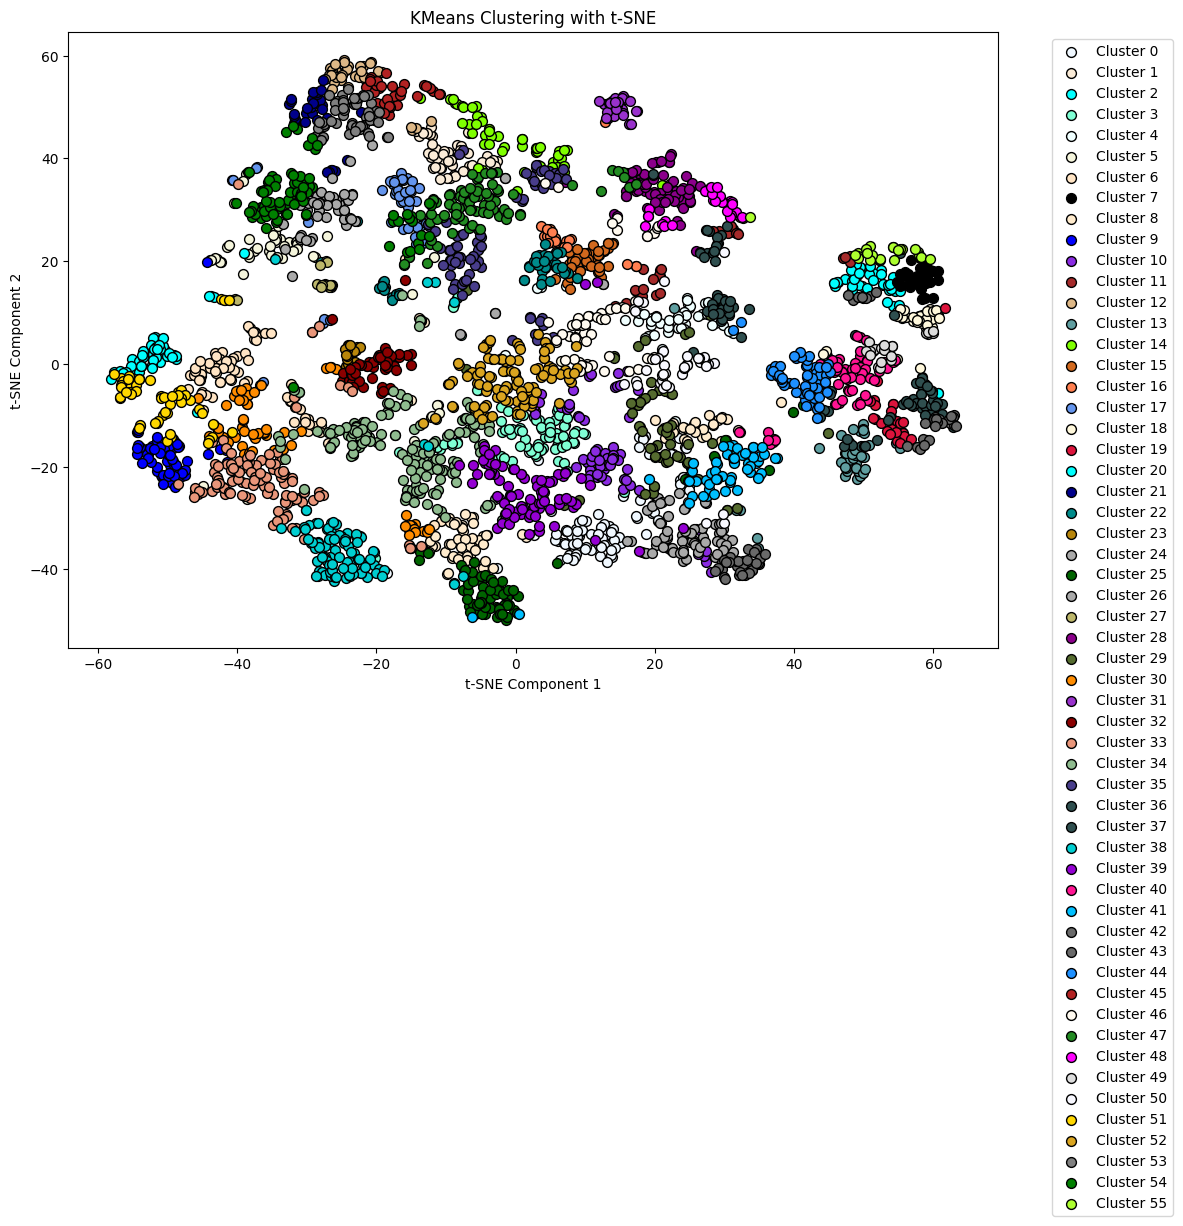

In [26]:
#visualized the best result

viz_clusering(pca_df_scaled, 'KMeans', 56)

# Test

In [27]:
beer_data_for_test = pd.read_csv(file_path)
beer_data_for_rec = beer_data_for_test.drop(columns = ['Description', 'review_aroma',	'review_appearance',	'review_palate',	'review_taste',	'review_overall',	'number_of_reviews'])

In [28]:
beer_names = beer_data_for_rec['Beer Name (Full)']
n_clusters = 56

kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 10)
best_labels = kmeans.fit_predict(pca_df_scaled)

# mappings to convert between beer names and indices.
beer_name_to_index = {name: idx for idx, name in enumerate(beer_names)}
index_to_beer_name = {idx: name for idx, name in enumerate(beer_names)}

beer_name = 'SweetWater Brewing Company Sweetwater IPA'


In [29]:
def get_cluster_number(beer_name, beer_name_to_index, labels):
  if beer_name not in beer_name_to_index:
    print(f"Beer name '{beer_name}' not found in the dataset.")
    return None

  beer_index = beer_name_to_index[beer_name]
  beer_cluster_label = labels[beer_index]

  return beer_cluster_label

cluster_number = get_cluster_number(beer_name, beer_name_to_index, best_labels)
print(cluster_number)


40


In [30]:
def recommend_beers(beer_name, beer_name_to_index, index_to_beer_name, labels):
  # get the cluster label for the input beer
  if beer_name not in beer_name_to_index:
    print(f"Beer name '{beer_name}' not found in the dataset.")
    return []

  beer_index = beer_name_to_index[beer_name]
  beer_cluster_label = labels[beer_index]

  # find all beers in the same cluster
  recommended_beers_indices = [i for i, label in enumerate(labels) if label == beer_cluster_label and i != beer_index]
  recommended_beers = [index_to_beer_name[idx] for idx in recommended_beers_indices]

  return recommended_beers[:5]

# fetch recommendations
recommended_beers = recommend_beers(beer_name, beer_name_to_index, index_to_beer_name, best_labels)
print(f"Recommended beers for '{beer_name}':\n\n" + "\n".join(recommended_beers))


Recommended beers for 'SweetWater Brewing Company Sweetwater IPA':

Ballast Point Brewing Company Ghost Pepper Sculpin
Lagunitas Brewing Company A Little Sumpin' Sumpin' Ale
Cigar City Brewing Jai Alai IPA
Russian River Brewing Company Blind Pig IPA
Maine Beer Company Lunch


In [31]:
input_beer_data = beer_data_for_rec[beer_data_for_rec['Beer Name (Full)'] == beer_name]
input_beer_data

,Name,Style,Brewery,Beer Name (Full),ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
828,IPA,IPA - American,SweetWater Brewing Company,SweetWater Brewing Company Sweetwater IPA,6.3,50,70,25,44,13,75,57,58,1,86,103,12,59


In [32]:
filtered_data = beer_data_for_rec[beer_data_for_rec['Beer Name (Full)'].isin(recommended_beers)]
filtered_data


,Name,Style,Brewery,Beer Name (Full),ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
800,Sculpin,IPA - American,Ballast Point Brewing Company,Ballast Point Brewing Company Ghost Pepper Scu...,7.00,50,70,20,34,12,69,43,53,0,72,92,4,28
804,A Little Sumpin' Sumpin' Ale,IPA - American,Lagunitas Brewing Company,Lagunitas Brewing Company A Little Sumpin' Sum...,7.50,50,70,15,32,14,58,23,56,1,69,100,2,65
805,Jai Alai IPA,IPA - American,Cigar City Brewing,Cigar City Brewing Jai Alai IPA,7.50,50,70,21,34,8,44,35,58,0,73,51,10,33
809,Blind Pig,IPA - American,Russian River Brewing Company,Russian River Brewing Company Blind Pig IPA,6.25,50,70,45,37,7,80,38,69,4,94,140,1,33
811,Lunch,IPA - American,Maine Beer Company,Maine Beer Company Lunch,7.00,50,70,26,54,15,64,56,79,0,97,102,5,49


#Cluster Examination

In [33]:
def fetch_beers_in_cluster(cluster_number, labels, beer_names, beer_data):
  beers_in_cluster_indices = [i for i, label in enumerate(labels) if label == cluster_number]
  beers_in_cluster = [index_to_beer_name[idx] for idx in beers_in_cluster_indices]
  cluster_data = beer_data.iloc[beers_in_cluster_indices]
  return beers_in_cluster, cluster_data

beers_in_cluster, cluster_data = fetch_beers_in_cluster(cluster_number, best_labels, beer_names, beer_data_for_test)

output_file_path = f'beers_in_cluster_{cluster_number}.csv'
cluster_data.to_csv(output_file_path, index = False)
print(f"Beers in cluster number {cluster_number} have been exported to {output_file_path}")

Beers in cluster number 40 have been exported to beers_in_cluster_40.csv


<ipython-input-34-ecb63a054b4d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = style_counts.index, y = style_counts.values, palette = 'viridis')


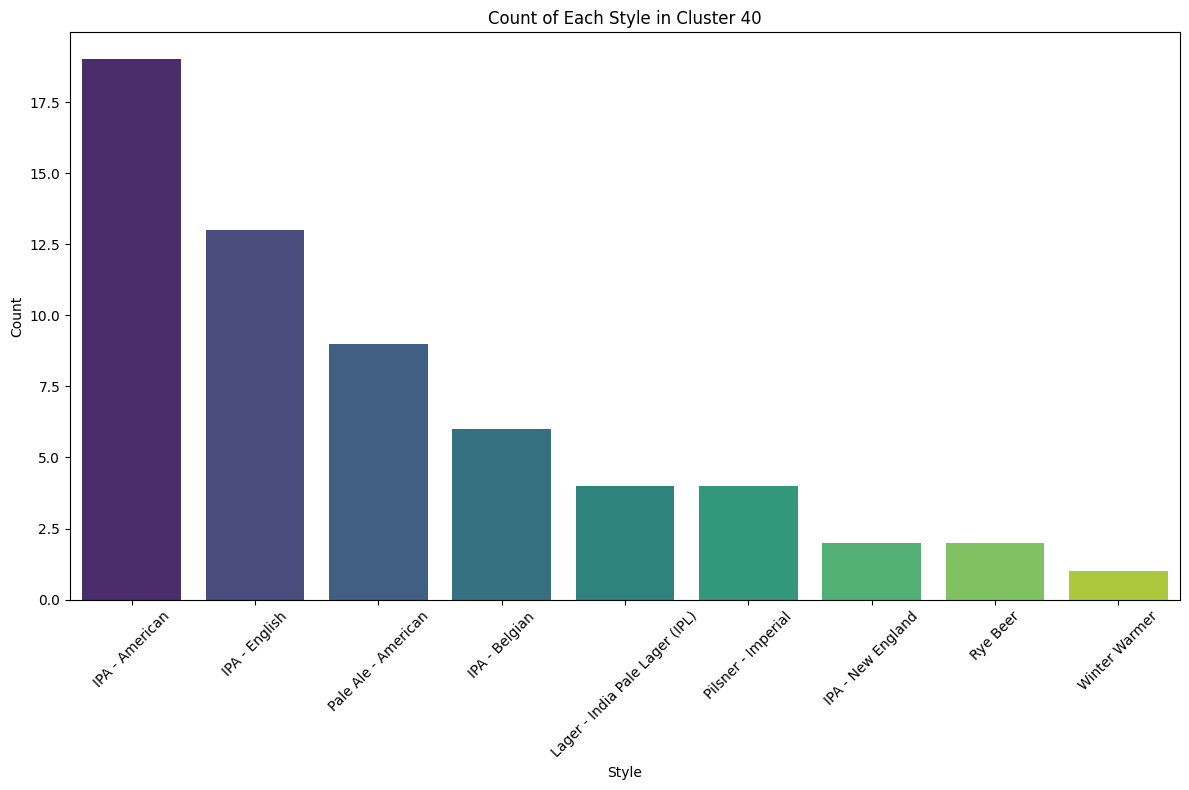

In [34]:
style_counts = cluster_data['Style'].value_counts()

plt.figure(figsize = (12, 8))
sns.barplot(x = style_counts.index, y = style_counts.values, palette = 'viridis')
plt.title(f'Count of Each Style in Cluster {cluster_number}')
plt.xlabel('Style')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


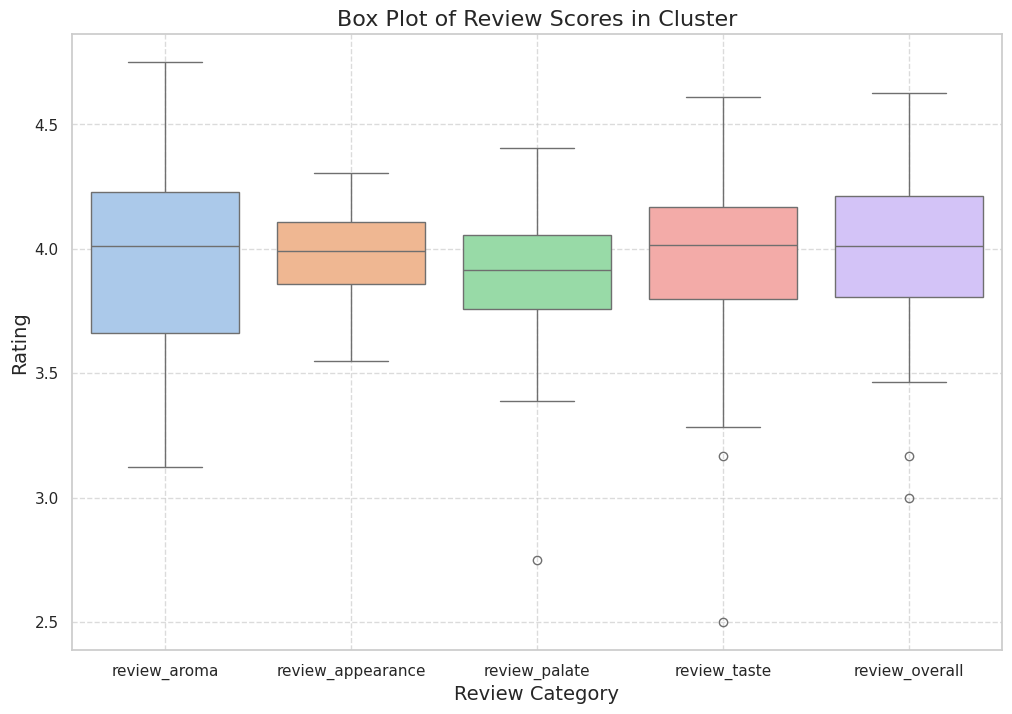

In [35]:
reviews = cluster_data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall']]

# Plot settings
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Box Plot of Review Scores
ax = sns.boxplot(data=reviews, palette='pastel')

# Title and labels
plt.title("Box Plot of Review Scores in Cluster", fontsize=16)
plt.xlabel("Review Category", fontsize=14)
plt.ylabel("Rating", fontsize=14)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()
plt.show()

In [36]:
# Get centroids of the clusters and WCSS for each cluster
centroids = kmeans.cluster_centers_
cluster_labels = np.unique(best_labels)
wcss_values = []

for label in cluster_labels:
    cluster_data_points = pca_df_scaled[best_labels == label]
    wcss = np.sum((cluster_data_points - centroids[label]) ** 2)
    wcss_values.append(wcss)

# the cluster with the lowest WCSS
best_cluster_idx = np.argmin(wcss_values)
best_cluster_label = cluster_labels[best_cluster_idx]
lowest_wcss = wcss_values[best_cluster_idx]

print(f"Best Cluster Label: {best_cluster_label}")
print(f"Lowest WCSS: {lowest_wcss}")

Best Cluster Label: 23
Lowest WCSS: 0.38519722070479673


In [37]:
#original data for the best cluster samples
best_cluster_indices = np.where(best_labels == best_cluster_label)[0]
best_cluster_samples_original = beer_data_for_rec.iloc[best_cluster_indices]
best_cluster_samples_original.drop(columns = ['Brewery', 'Name',	'Beer Name (Full)'], inplace=True)
best_cluster_samples_original

<ipython-input-37-90a08c469f67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_cluster_samples_original.drop(columns = ['Brewery', 'Name',	'Beer Name (Full)'], inplace=True)


,Style,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
1234,Lager - European Strong,10.0,15,40,9,36,77,33,59,31,1,36,31,4,32
1237,Lager - European Strong,12.0,15,40,7,21,70,12,33,8,1,11,6,0,27
1239,Lager - European Strong,9.0,15,40,10,27,76,16,53,22,0,10,17,1,49
1241,Lager - European Strong,9.5,15,40,13,37,62,22,83,24,6,30,30,17,52
1243,Lager - European Strong,10.0,15,40,10,9,58,27,44,13,0,15,22,0,39
1247,Lager - European Strong,9.0,15,40,13,17,78,15,37,6,2,11,11,6,39
1250,Lager - European Strong,8.4,15,40,1,19,19,18,63,13,0,15,20,2,30
1393,Lager - Malt Liquor,8.0,10,30,9,19,32,13,40,12,0,10,16,0,43
1394,Lager - Malt Liquor,8.0,10,30,9,39,39,23,44,15,0,14,24,1,43
1402,Lager - Malt Liquor,10.5,10,30,8,21,52,12,50,25,0,33,10,8,31


In [38]:
print('The size of the cluster:', len(best_cluster_samples_original))

The size of the cluster: 17


Statistics for each cluster

In [39]:
#  get top N modes and their counts from a Series
def get_top_modes(series, n=2):
    mode_counts = series.value_counts()
    modes = mode_counts.index[:n]
    counts = mode_counts[modes].tolist()
    return modes.tolist(), counts

In [40]:
# extract and align styles and counts
def extract_styles_and_counts(row, idx):
    if len(row['Dominant_Styles'][0]) > idx:
        return row['Dominant_Styles'][0][idx], row['Dominant_Styles'][1][idx]
    else:
        return 'Not have', 0

In [45]:
beer_data_for_rec['Cluster'] = kmeans.labels_

# Group by 'Cluster' and aggregate to find count, top 2 modes, and their counts
summary_statistics = beer_data_for_rec.groupby('Cluster')['Style'].agg([
    ('Count', 'size'),
    ('Dominant_Styles', lambda x: get_top_modes(x, 2))
]).reset_index()

# orginaize the table
summary_statistics['Dominant_Style1'], summary_statistics['Count_Style1'] = zip(*summary_statistics.apply(lambda row: extract_styles_and_counts(row, 0), axis=1))
summary_statistics['Count_Style1'] = summary_statistics['Count_Style1'].astype(int)
summary_statistics['Proportion_Style1'] = round(summary_statistics['Count_Style1'] / summary_statistics['Count'], 2)
summary_statistics['Dominant_Style2'], summary_statistics['Count_Style2'] = zip(*summary_statistics.apply(lambda row: extract_styles_and_counts(row, 1), axis=1))

summary_statistics = summary_statistics.drop(columns=['Dominant_Styles'])

summary_statistics['Count_Style2'] = summary_statistics['Count_Style2'].astype(int)
summary_statistics['Proportion_Style2'] = round(summary_statistics['Count_Style2'] / summary_statistics['Count'], 2)

summary_statistics = summary_statistics.drop(['Count_Style1','Count_Style2'], axis=1)
# summary_statistics.to_csv('statistics_clusters.csv', index = True)
summary_statistics

,Cluster,Count,Dominant_Style1,Proportion_Style1,Dominant_Style2,Proportion_Style2
0,0,95,Stout - Irish Dry,0.17,Bitter - English,0.14
1,1,54,Farmhouse Ale - Saison,0.33,Pale Ale - Belgian,0.19
2,2,44,Strong Ale - American,0.30,Stout - Russian Imperial,0.25
3,3,87,Lager - Märzen / Oktoberfest,0.17,Lager - Munich Dunkel,0.15
4,4,53,Winter Warmer,0.26,Strong Ale - English,0.19
5,5,50,Wheat Beer - Dunkelweizen,0.38,Kvass,0.16
6,6,89,Mild Ale - English Pale,0.12,Mild Ale - English Dark,0.10
7,7,35,Barleywine - American,0.66,IPA - Imperial,0.09
8,8,80,Pale Ale - English,0.19,Pale Ale - American,0.15
9,9,67,Lager - Light,0.30,Low Alcohol Beer,0.30
